# Output Cell Type Classifier

In [2]:
#---Inports---
#import numpy and keras modules
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

#import Scanpy modules
import scanpy as sc
import anndata as ad

#import os and matplotlib
import os
import matplotlib 
import matplotlib.pyplot as plt

#import sklearn modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Set a random seed for reproducibility
random_seed = 42

In [3]:
#---Data loading---
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'data')

#Name of data set
dataset_name = 'large_atac_gene_activity'

# read dataset into an anndata object:  Category - Cells of the brain
inPath = os.path.join(base_path, f"{dataset_name}.h5ad")
adata = sc.read(inPath)
INPUT = adata.X.toarray()

In [4]:
#---Prepare Data---
#Encode the cell labels as One hot vector to use as output
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
OUTPUT = encoder.fit_transform(adata.obs[['final_cell_label']])

#Perform a Train Test Split
INPUT_train, INPUT_test, OUTPUT_train, OUTPUT_test = train_test_split(INPUT, OUTPUT, test_size=0.2, random_state=random_seed)

#Output and Input size of NN
INPUT_size = INPUT[0].size
OUTPUT_size = OUTPUT[0].size


In [5]:
#---Build the model---
#Initilize the model
model = Sequential()
#Define Hyperparameters
OPTIMIZER = 'adam'                  #optimizer
LOSS = 'categorical_crossentropy'   # loss function
N_HIDDEN = 256                      # Number of nodes in hidden layers
ACTIVATION_FUNCTION = 'relu'        #activation function
L2_LAMBDA = 0.0075                   # Regularization strength

# First hidden layer with L2 regularization
model.add(Dense(N_HIDDEN, input_shape=(INPUT_size,), activation=ACTIVATION_FUNCTION, kernel_regularizer=l2(L2_LAMBDA)))

# Second hidden layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2_LAMBDA)))

# Output layer (softmax for multi-class classification)
model.add(Dense(OUTPUT_size, activation='softmax'))

# Summary of the whole model
model.summary()

# model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

c:\Users\lklei\anaconda3\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       916,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 950,535 (3.63 MB)

 Trainable params: 950,535 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#---Train the model---
#Hyperparameters
BATCH_SIZE = 32
N_EPOCH = 15

#Fit the input to the output
history = model.fit(INPUT_train, OUTPUT_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=2, validation_split=0.2)

#test the network
score = model.evaluate(INPUT_test, OUTPUT_test, verbose=2)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/15
1697/1697 - 6s - 3ms/step - accuracy: 0.9023 - loss: 0.7868 - val_accuracy: 0.9201 - val_loss: 0.4711
Epoch 2/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9229 - loss: 0.4416 - val_accuracy: 0.9154 - val_loss: 0.4322
Epoch 3/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9320 - loss: 0.3796 - val_accuracy: 0.9328 - val_loss: 0.3593
Epoch 4/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9346 - loss: 0.3497 - val_accuracy: 0.9318 - val_loss: 0.3540
Epoch 5/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9370 - loss: 0.3285 - val_accuracy: 0.9329 - val_loss: 0.3324
Epoch 6/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9385 - loss: 0.3179 - val_accuracy: 0.9331 - val_loss: 0.3246
Epoch 7/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9411 - loss: 0.3088 - val_accuracy: 0.9255 - val_loss: 0.3445
Epoch 8/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9403 - loss: 0.3063 - val_accuracy: 0.9340 - val_loss: 0.3251
Epoch 9/15
1697/1697 - 5s - 3ms/step - accuracy: 0.9408 - loss: 0.3009 - val_accuracy: 0.9370 - 

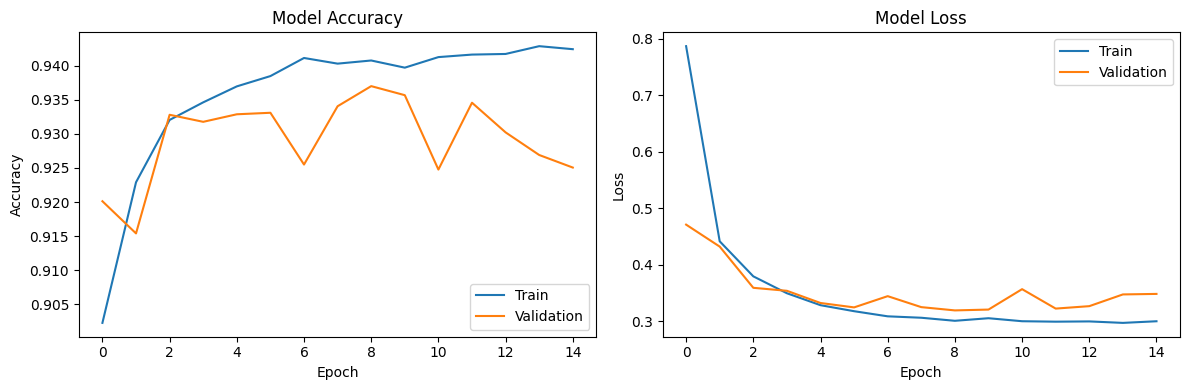

In [7]:
#--Visualisize Training---
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
#Plots show Accuracy improvment with training and loss decreasing only with Train and validation data: no overfitting
#Accuracy is high